In [ ]:
import cv2
import numpy as np
import glob

## Thresholding and Instensity Measurement

In [ ]:
# Use a glob pattern to find all patch images
image_paths = glob.glob("/original_patches/patch_*.png")
# Sort them if you want to ensure a consistent order (optional)
image_paths = sorted(image_paths)

intensity_values = []

for img_path in image_paths:
    # 1. Read the image in grayscale
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Failed to load image: {img_path}")
        continue

    # 2. Apply Otsu's thresholding
    # This separates the bright fluorescent spot from the background
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 3. Find contours in the binary mask
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        print(f"No bright spot found in image: {img_path}")
        continue

    # Assume the largest contour corresponds to the fluorescent spot
    largest_contour = max(contours, key=cv2.contourArea)

    # 4. Create a mask from the largest contour
    mask = np.zeros_like(image, dtype=np.uint8)
    cv2.drawContours(mask, [largest_contour], -1, 255, -1)

    # 5. Extract pixel intensities within the mask (the spot region)
    spot_pixels = image[mask == 255]
    mean_intensity = np.mean(spot_pixels)

    intensity_values.append((img_path, mean_intensity))


In [ ]:
# Print out the results
import os

# Suppose your project directory is '/Image-Augmentation-Salmonella'
# and your CSV expects 'original_patches/patch_0.png'.
# You can use os.path.relpath to convert the absolute path to relative.

project_root = "/Image-Augmentation-Salmonella"
df_intensity = pd.DataFrame(intensity_values, columns=['Full_Path', 'Intensity'])

# Convert Full_Path to a relative path that matches CSV
df_intensity['Image_Path'] = df_intensity['Full_Path'].apply(
    lambda p: os.path.relpath(p, project_root)
)

# Now df_intensity['Image_Path'] should be something like 'original_patches/patch_0.png'
df_intensity = df_intensity[['Image_Path', 'Intensity']]  # Keep only needed columns

In [ ]:

updated_intensity_values = []
for img_path, intensity in intensity_values:
    # Convert absolute path to a relative path
    rel_path = os.path.relpath(img_path, project_root)
    updated_intensity_values.append((rel_path, intensity))

# Now print the updated list with relative paths
for img_path, intensity in updated_intensity_values:
    print(f"Image: {img_path}, Mean Intensity: {intensity}")

In [ ]:
import pandas as pd

# Suppose the original CSV file is named 'concentrations.csv' and looks like:
# Image_Path,Concentration_Level
# original_patches/patch_0.png,0
# original_patches/patch_1.png,1
# ... and so on

# Now updated_intensity_values should match the paths in your CSV
df_conc = pd.read_csv('/Image-Augmentation-Salmonella/image_labels.csv')

# Create the intensity DataFrame using the updated relative paths
df_intensity = pd.DataFrame(updated_intensity_values, columns=['Image_Path', 'Intensity'])

# Merge on Image_Path
df_merged = pd.merge(df_conc, df_intensity, on='Image_Path', how='left')

df_merged.to_csv('concentrations_with_intensity.csv', index=False)
print("Merged CSV file created: concentrations_with_intensity.csv")

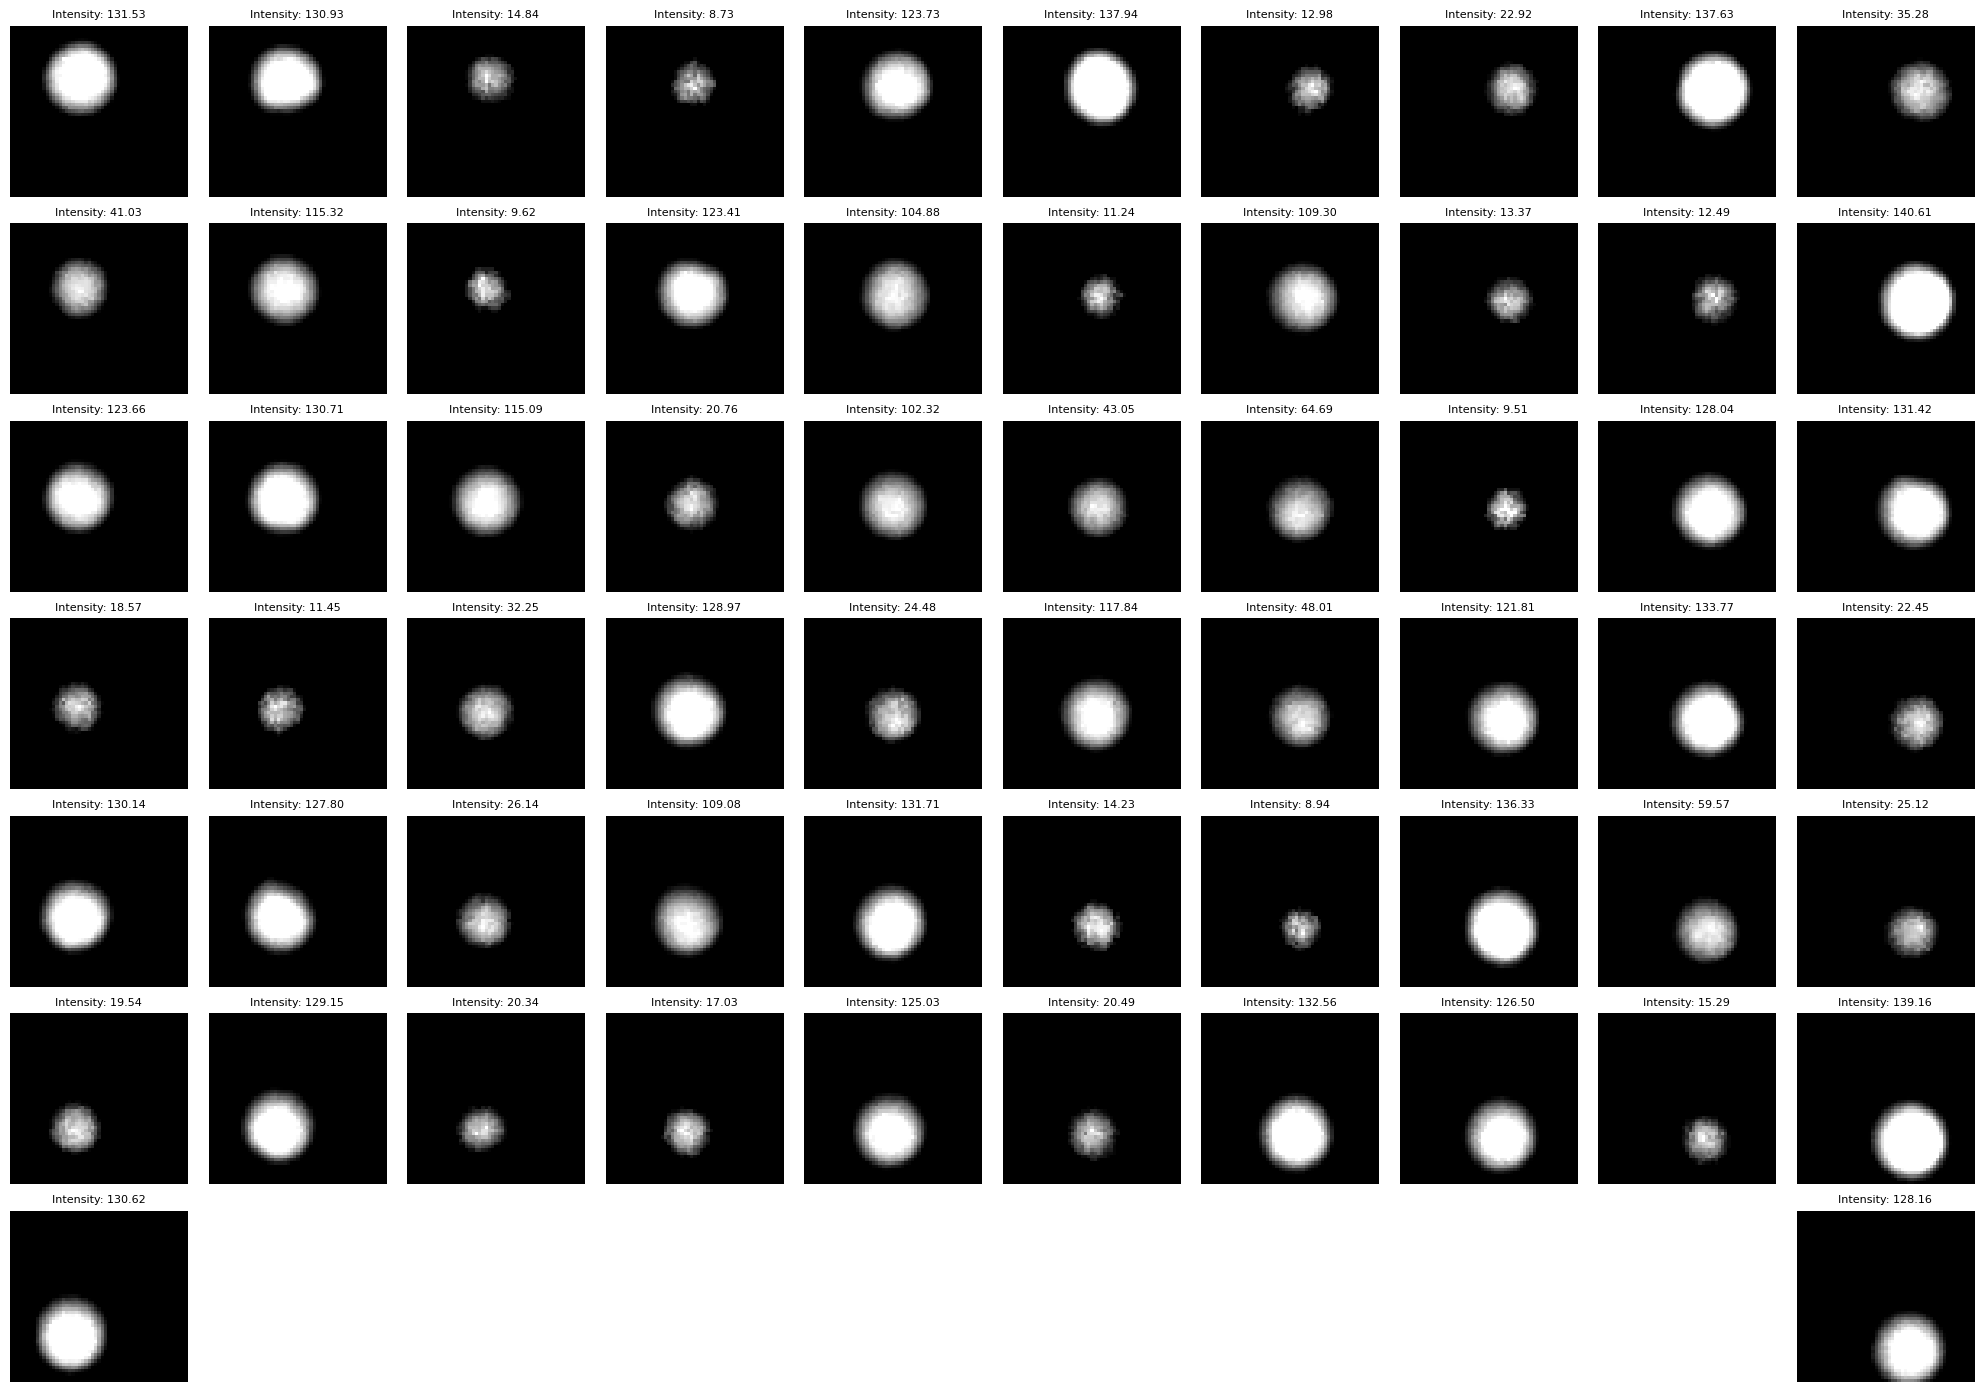

In [133]:
import re
import matplotlib.pyplot as plt
import cv2

# intensity_values: [(img_path, mean_intensity), (img_path, mean_intensity), ...]
# Example: intensity_values might be unsorted: patch_10, patch_2, patch_0, etc.

# Extract patch index using a regex or string splitting
def extract_patch_number(img_path):
    # img_path might be something like "original_patches/patch_10.png"
    match = re.search(r'patch_(\d+)\.png', img_path)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Could not extract patch number from {img_path}")

# Sort intensity_values by patch number
intensity_values_sorted = sorted(intensity_values, key=lambda x: extract_patch_number(x[0]))

# Now intensity_values_sorted should be in the order patch_0, patch_1, patch_2, ... patch_61

# Plotting with the fixed order
rows = 7
cols = 10
fig, axes = plt.subplots(rows, cols, figsize=(20, 14))
axes = axes.flatten()

# Place patch_0 through patch_59 at indices 0 to 59
for idx in range(60):
    img_path, mean_intensity = intensity_values_sorted[idx]
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        axes[idx].imshow(image, cmap='gray')
        axes[idx].set_title(f"Intensity: {mean_intensity:.2f}", fontsize=18)
    else:
        axes[idx].set_title("Failed to load", fontsize=18)
    axes[idx].axis("off")

# Place patch_60 at index 60 (61st slot)
img_path_60, mean_intensity_60 = intensity_values_sorted[60]
image_60 = cv2.imread(img_path_60, cv2.IMREAD_GRAYSCALE)
if image_60 is not None:
    axes[60].imshow(image_60, cmap='gray')
    axes[60].set_title(f"Intensity: {mean_intensity_60:.2f}", fontsize=18)
else:
    axes[60].set_title("Failed to load", fontsize=18)
axes[60].axis("off")

# Leave indices 61 through 68 blank
for blank_idx in range(61, 69):
    axes[blank_idx].axis("off")

# Place patch_61 at index 69 (70th slot)
img_path_61, mean_intensity_61 = intensity_values_sorted[61]
image_61 = cv2.imread(img_path_61, cv2.IMREAD_GRAYSCALE)
if image_61 is not None:
    axes[69].imshow(image_61, cmap='gray')
    axes[69].set_title(f"Intensity: {mean_intensity_61:.2f}", fontsize=18)
else:
    axes[69].set_title("Failed to load", fontsize=18)
axes[69].axis("off")

plt.tight_layout()
plt.show()

## Model Training - 1 - Multi-class Classification

In [134]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('concentrations_with_intensity.csv')

X = df[['Intensity']]  # Features
y = df['Concentration_Level']  # Target (Categorical)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [136]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [137]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)  # Predicted classes
y_proba = clf.predict_proba(X_test)  # Class probabilities
acc = accuracy_score(y_test, y_pred)
import numpy as np
confidences = np.max(y_proba, axis=1)
print("Accuracy:", acc)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.33      1.00      0.50         2
           2       1.00      0.17      0.29         6
           3       0.60      0.75      0.67         4

    accuracy                           0.76        25
   macro avg       0.73      0.73      0.61        25
weighted avg       0.88      0.76      0.74        25



## Model Training - 2 - Binary Classification

In [ ]:
## Model Training - 2 - Binary Classification (0 vs. Not 0)

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Convert the multi-class labels into binary labels:
# 0 remains 0, and anything else (1, 2, 3) becomes 1.
y_binary = (y != 0).astype(int)

# Split the data into training and test sets
X_train, X_test, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.4, random_state=42)

# Initialize and train the Random Forest classifier
clf_binary = RandomForestClassifier(n_estimators=100, random_state=42)
clf_binary.fit(X_train, y_train_binary)

# Predict on the test set
y_pred_binary = clf_binary.predict(X_test)

# Calculate accuracy
acc_binary = accuracy_score(y_test_binary, y_pred_binary)
print("Binary Classification Accuracy (0 vs. Not 0):", acc_binary)

# Print classification report
# "Class 0" corresponds to the original 0 class, "Not 0" corresponds to classes 1,2,3 combined
print("Classification Report (Binary):\n", classification_report(y_test_binary, y_pred_binary, target_names=["Class 0", "Not 0"]))

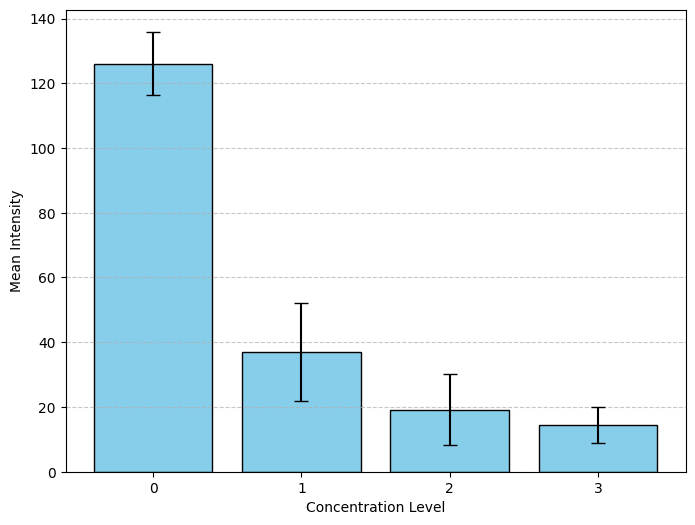

In [139]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with columns:
# 'Concentration_Level' (categorical: 0,1,2,3) and 'Intensity' (float)
# Example:
# df = pd.read_csv('concentrations_with_intensity.csv')

# Calculate mean and standard deviation of intensity for each class
class_stats = df.groupby('Concentration_Level')['Intensity'].agg(['mean', 'std'])

# Plotting
plt.figure(figsize=(8,6))
# Convert the index to string for cleaner x-axis labels if needed
x_labels = class_stats.index.astype(str)

# Plot a bar chart for mean intensities with error bars as standard deviation
plt.bar(x_labels, class_stats['mean'], yerr=class_stats['std'], 
        capsize=5, color='skyblue', edgecolor='black')

# Labeling the axes and adding a title
plt.xlabel("Concentration Level")
plt.ylabel("Mean Intensity")
plt.title("Mean Intensity per Concentration Level with Error Bars")

# Optional: Add a grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## Testing on the Entire Dataset

Accuracy on the entire dataset: 0.9032258064516129
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.71      1.00      0.83        10
           2       1.00      0.50      0.67        10
           3       0.82      0.90      0.86        10

    accuracy                           0.90        62
   macro avg       0.88      0.85      0.84        62
weighted avg       0.92      0.90      0.90        62



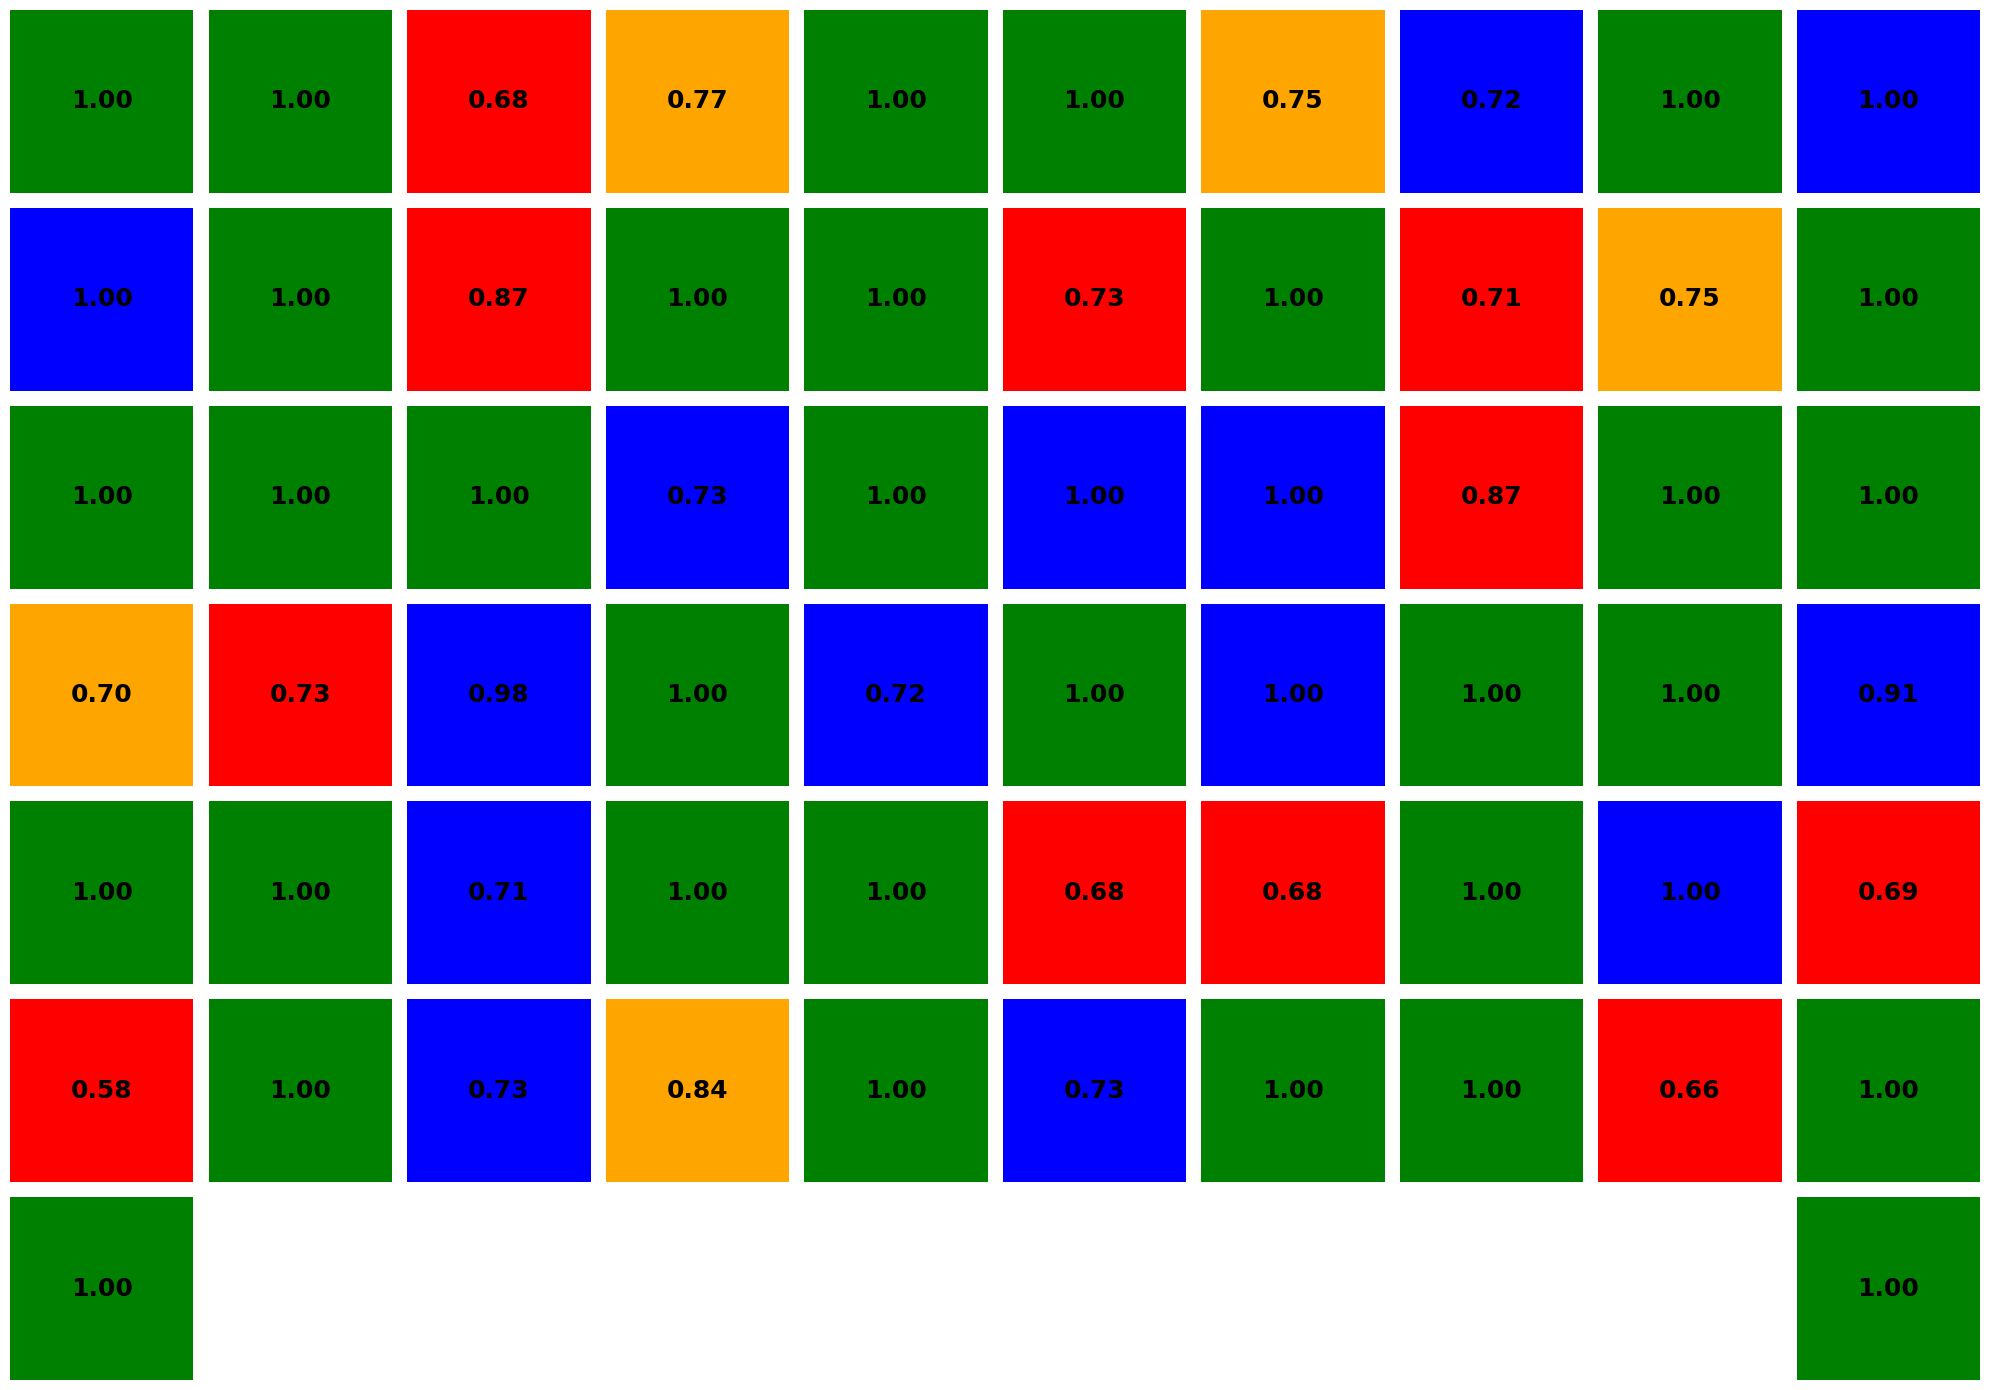

In [144]:
import matplotlib.pyplot as plt
import re

df['Patch_Number'] = df['Image_Path'].apply(lambda p: extract_patch_number(p))
df_sorted = df.sort_values(by='Patch_Number')

# Now re-extract X and y, then predict again
X_all_sorted = df_sorted[['Intensity']]
y_all_sorted = df_sorted['Concentration_Level']

y_pred_all_sorted = clf.predict(X_all_sorted)
y_proba_all_sorted = clf.predict_proba(X_all_sorted)
confidences_all_sorted = np.max(y_proba_all_sorted, axis=1)
accuracy_all = accuracy_score(y_all_sorted, y_pred_all_sorted)
print("Accuracy on the entire dataset:", accuracy_all)
print("Classification Report:\n", classification_report(y_all_sorted, y_pred_all_sorted))

def extract_patch_number(img_path):
    match = re.search(r'patch_(\d+)\.png', img_path)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Could not extract patch number from {img_path}")

intensity_values_sorted = sorted(intensity_values, key=lambda x: extract_patch_number(x[0]))

# Ensure that y_pred and confidences correspond in order to intensity_values_sorted

rows = 7
cols = 10
fig, axes = plt.subplots(rows, cols, figsize=(20, 14))
axes = axes.flatten()

# Assuming y_pred_all and confidences_all are arrays of length 62
# and that the data is in the desired order (patch_0 to patch_61).

colors = {0: "green", 1: "blue", 2: "orange", 3: "red"}  # Adjust if needed

# Indices 0 to 59 for patch_0 through patch_59
for idx in range(60):
    pred_class = y_pred_all_sorted[idx]
    conf = confidences_all_sorted[idx]

    axes[idx].add_patch(plt.Rectangle((0,0), 1,1, color=colors[pred_class]))
    axes[idx].text(0.5, 0.5, f"{conf:.2f}", color="black", fontweight="bold",
                   ha="center", va="center", fontsize=18)
    axes[idx].axis("off")

# Patch_60 at index 60 (61st slot)
pred_class_60 = y_pred_all_sorted[60]
conf_60 = confidences_all_sorted[60]
axes[60].add_patch(plt.Rectangle((0,0), 1,1, color=colors[pred_class_60]))
axes[60].text(0.5, 0.5, f"{conf_60:.2f}", color="black", fontweight="bold",
              ha="center", va="center", fontsize=18)
axes[60].axis("off")

# Leave indices 61 through 68 blank
for blank_idx in range(61, 69):
    axes[blank_idx].axis("off")

# Patch_61 at index 69 (70th slot)
pred_class_61 = y_pred_all_sorted[61]
conf_61 = confidences_all_sorted[61]
axes[69].add_patch(plt.Rectangle((0,0), 1,1, color=colors[pred_class_61]))
axes[69].text(0.5, 0.5, f"{conf_61:.2f}", color="black", fontweight="bold",
              ha="center", va="center", fontsize=18)
axes[69].axis("off")

plt.tight_layout()
plt.show()

## Testing on the Entire Dataset - Binary

Accuracy on the entire dataset (Binary): 1.0
Classification Report (Binary):
               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        32
       Not 0       1.00      1.00      1.00        30

    accuracy                           1.00        62
   macro avg       1.00      1.00      1.00        62
weighted avg       1.00      1.00      1.00        62



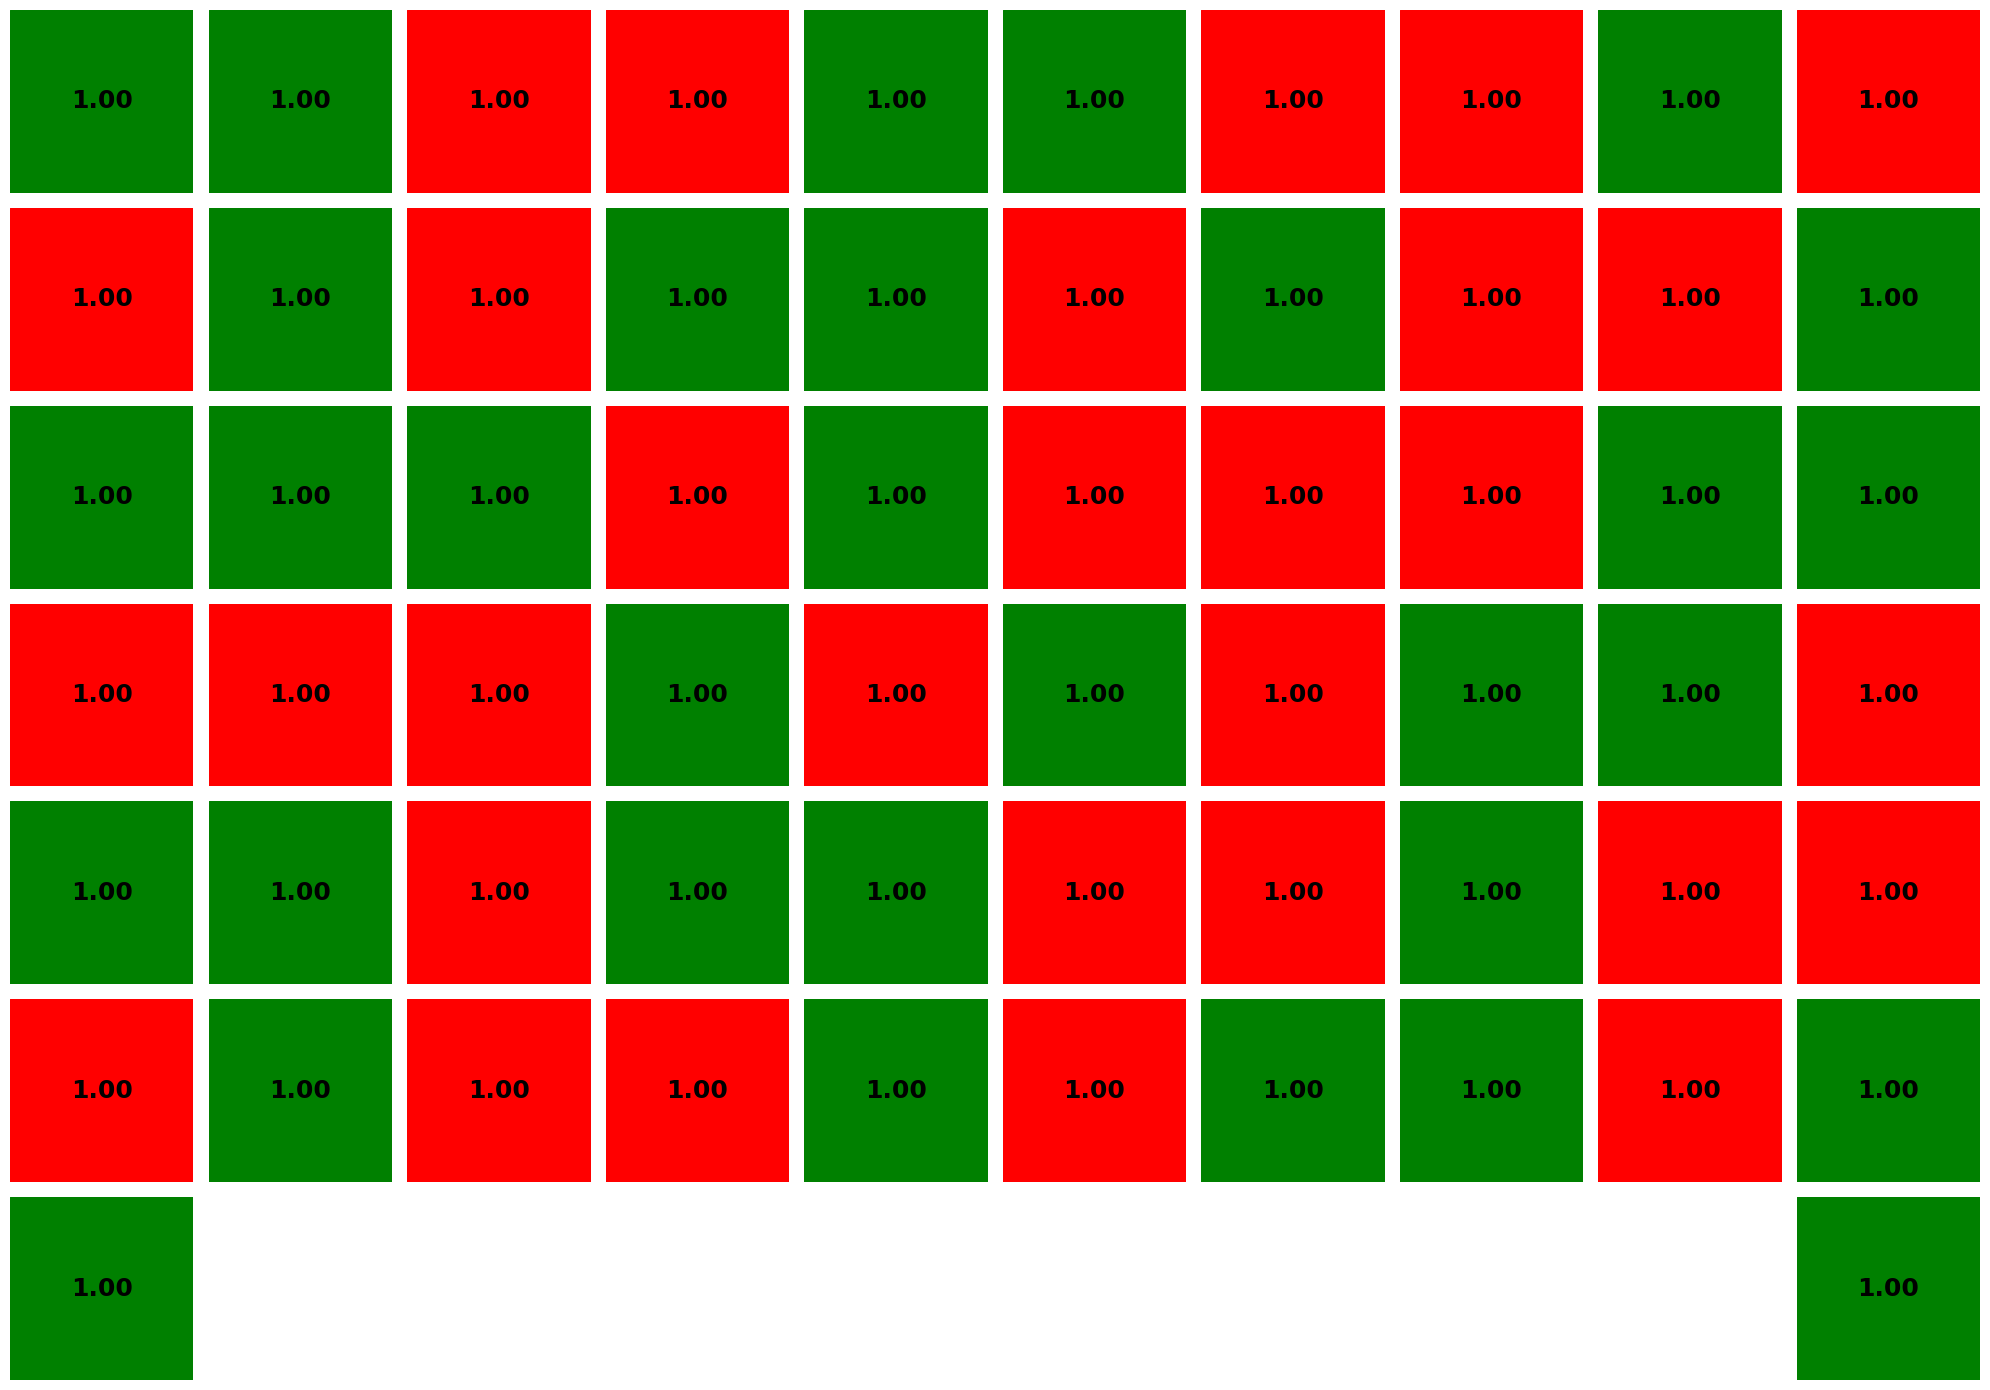

In [143]:
import re
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Convert y_all_sorted to binary: 0 stays 0, everything else becomes 1
y_all_sorted_binary = (y_all_sorted != 0).astype(int)

# Make predictions on the entire sorted dataset
y_pred_all_sorted_binary = clf.predict(X_all_sorted)
y_proba_all_sorted_binary = clf.predict_proba(X_all_sorted)
confidences_all_sorted_binary = np.max(y_proba_all_sorted_binary, axis=1)

# Since clf is still a multi-class model, ensure that predictions are also treated as binary
# If clf is already trained for binary classification, this step isn't needed.
# For a model trained for binary classification, y_pred_all_sorted_binary will already be in {0,1}.
# If it's a 4-class model, you need to convert predictions to binary:
y_pred_all_sorted_binary = (y_pred_all_sorted_binary != 0).astype(int)

# Evaluate accuracy and report for binary classification
accuracy_all_binary = accuracy_score(y_all_sorted_binary, y_pred_all_sorted_binary)
print("Accuracy on the entire dataset (Binary):", accuracy_all_binary)
print("Classification Report (Binary):\n", 
      classification_report(y_all_sorted_binary, y_pred_all_sorted_binary, target_names=["Class 0", "Not 0"]))

def extract_patch_number(img_path):
    match = re.search(r'patch_(\d+)\.png', img_path)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Could not extract patch number from {img_path}")

intensity_values_sorted = sorted(intensity_values, key=lambda x: extract_patch_number(x[0]))
# If you just want to plot the binary predictions and confidences:
rows = 7
cols = 10
fig, axes = plt.subplots(rows, cols, figsize=(20, 14))
axes = axes.flatten()

colors_binary = {0: "green", 1: "red"}

# Indices 0 to 59 for patch_0 through patch_59
for idx in range(60):
    pred_class = y_pred_all_binary[idx]
    conf = confidences_all_binary[idx]
    axes[idx].add_patch(plt.Rectangle((0,0), 1,1, color=colors_binary[pred_class]))
    axes[idx].text(0.5, 0.5, f"{conf:.2f}", color="black", fontweight="bold",
                   ha="center", va="center", fontsize=18)
    axes[idx].axis("off")

# Patch_60 at index 60 (61st slot)
pred_class_60 = y_pred_all_binary[60]
conf_60 = confidences_all_binary[60]
axes[60].add_patch(plt.Rectangle((0,0), 1,1, color=colors_binary[pred_class_60]))
axes[60].text(0.5, 0.5, f"{conf_60:.2f}", color="black", fontweight="bold",
              ha="center", va="center", fontsize=18)
axes[60].axis("off")

# Leave indices 61 through 68 blank
for blank_idx in range(61, 69):
    axes[blank_idx].axis("off")

# Patch_61 at index 69 (70th slot)
pred_class_61 = y_pred_all_binary[61]
conf_61 = confidences_all_binary[61]
axes[69].add_patch(plt.Rectangle((0,0), 1,1, color=colors_binary[pred_class_61]))
axes[69].text(0.5, 0.5, f"{conf_61:.2f}", color="black", fontweight="bold",
              ha="center", va="center", fontsize=18)
axes[69].axis("off")

plt.tight_layout()
plt.show()